## Backhoe Barge Hopper Simulation

This notebook is used to simulate different setups for three types of equipment available to be used for maintenance dreding as follows.

* Backhoe Dredger that uses separate identical barges to transport the dredged sediments to the designated dump location.
* Trailing Suction Hopper Dredger (TSHD) that moves back and forth to dredge the sediments and make sure that the berth location is fully dredged.

The scenarios vary based on the type of equipment being used, number of equipment from each type, and the total amount of sediment being dredged.
The simulations are done for one Backhoe dredger that incorporates multiple identical barges to re-allocate the dredged sediments. Moreover, TSHDs can be also used for the re-allocation of sediments. All the dredged material are discharged in the dump location.

You can refer to the following references to get more information on how this simulation works.

 * https://github.com/TUDelft-CITG/OpenCLSim/blob/master/notebooks/34_fleet_optimization.ipynb
 * https://pure.tudelft.nl/ws/portalfiles/portal/161150813/Terra_et_Aqua_170_Summer_2023_TECHNICAL_single_pages.pdf

Multiple simulation scenarios are developed to compare how duration and emission of the whole project change with different types and numbers of equipment.

The fleet list can be found here: https://www.iadc-dredging.com/publication/iadc-fleet-list-2023-2/ 

### 0. Import libraries
Libraries are imported which can be used for defining the objects in the simulation, implement the simulation, and visualize the results.

In [183]:
# libraries used for numerical and data analysis
import pandas as pd
import shapely
from numpy import random

# libraries used for the simulation
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

### 1. Define object classes
Object classes are used to assign different attributes to objects (Sites for important locations and TransportProcessingResource for vessels).

They are basically referred to the source code of OpenCLSim by calling the classes that are used to define these attributes.

In [184]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.Log,
    ),
    {},
)

### 2. Define objects (sites, vessels, and activities) and run the simulation

The following code defines all the objects being used during the simulation (sites and vessels) and the activities that trigger the simulation for these objects.

The main structure of the simulation consists of the following items:
* define the simulation run that consists of variables that can be controlled during the simulation
* define the simulation environment along with start/stop time for the simulation
* define the registry that makes sure all the processes are registered within the simulation environment
* define the sites (berth, dump, etc.) with their specific characteristics
* define the vessels with their specific characteristics (the number of vessels of the same type can also be controlled in the simulation)
* define the activities that are used to simulate the processes for vessels among the sites
* the desired processes should be registered before running the simulation

In [185]:
def run(nr_tshd, nr_barge, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    
    #create site objects
    location_berth = shapely.geometry.Point(4.18055556, 52.18664444)
    data_berth = {"env": my_env,
                      "name": "berth",
                      "geometry": location_berth,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":2}
    berth = Site(**data_berth)

    location_dump = shapely.geometry.Point(4.25222222, 52.11428333)
    data_dump = {"env": my_env,
                    "name": "dump",
                    "geometry": location_dump,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":2}
    dump = Site(**data_dump)
    
    #create vessel objects
    vessels = {}
    
    for i in range (nr_tshd):
        vessels[f"tshd{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"tshd{i}",
            geometry=location_dump,
            capacity=2000,
            compute_v=lambda x: 10
        )
    tshd = TransportProcessingResource(
        env=my_env,
        name=f"tshd{i}",
        geometry=location_dump,
        capacity=2000,
        compute_v=lambda x: 10
    )
    for i in range (nr_barge):
        vessels[f"barge{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"barge{i}",
            geometry=location_dump,
            capacity=4000,
            compute_v=lambda x: 7
        )
    backhoe = TransportProcessingResource(
        env=my_env,
        name="backhoe",
        geometry=location_berth,
        capacity=0,
        compute_v=lambda x: 0
    )
    
    vessels['tshd'] = tshd
    vessels['backhoe'] = backhoe
       
    activities_tshd = {}
    
    for i in range (nr_tshd):
        requested_resources={}

        
        subprocesses_tshd = [
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        mover=vessels[f"tshd{i}"],
                        destination=berth,
                        duration=1*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        processor=vessels[f"tshd{i}"],
                        origin=berth,
                        destination=vessels[f"tshd{i}"],
                        amount=2000,
                        duration=2*3600,
                        requested_resources=requested_resources,
                    ),
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing full: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        mover=vessels[f"tshd{i}"],
                        destination=dump,
                        duration=1.5*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        processor=vessels[f"tshd{i}"],
                        origin=vessels[f"tshd{i}"],
                        destination=dump,
                        amount=2000,
                        duration=0.5*3600,
                        requested_resources=requested_resources,
                    )
        ]
        
        activities_tshd[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle_tshd{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle_tshd{i}",
                registry=registry,
                sub_processes= subprocesses_tshd
            )],
             condition_event=[{"type": "container",
                              "concept": berth,
                              "state": "empty",
                              "id_":"default_reservations"}
                             ]
        )


    
    activities_backhoe_barge = {}

    for i in range (nr_barge):
        requested_resources={}

        subprocesses_backhoe_barge = [
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[f"barge{i}"].name,
                        registry=registry,
                        mover=vessels[f"barge{i}"],
                        destination=berth,
                        duration=1*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[f"barge{i}"].name,
                        registry=registry,
                        processor=backhoe,
                        origin=berth,
                        destination=vessels[f"barge{i}"],
                        amount=4000,
                        duration=4*3600,
                        requested_resources=requested_resources,
                    ),
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[f"barge{i}"].name,
                        registry=registry,
                        mover=vessels[f"barge{i}"],
                        destination=dump,
                        duration=1.5*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading: "+vessels[f"barge{i}"].name,
                        registry=registry,
                        processor=vessels[f"barge{i}"],
                        origin=vessels[f"barge{i}"],
                        destination=dump,
                        amount=4000,
                        duration=0.5*3600,
                        requested_resources=requested_resources,
                    )
        ]
         
        activities_backhoe_barge[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle_barge{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle_barge{i}",
                registry=registry,
                sub_processes= subprocesses_backhoe_barge,
            )],
             condition_event=[{"type": "container",
                              "concept": berth,
                              "state": "empty",
                              "id_":"default_reservations"}
                             ]
        )        
                           
    model.register_processes([*activities_tshd.values(), *activities_backhoe_barge.values()])
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities_tshd": activities_tshd,
        "activities_backhoe_barge": activities_backhoe_barge,
        "berth":berth,
        "dump":dump,
    }

### 3. Control the problem variables and show the output
The problem variables need to be controled to determine the simulation output for different scenarios.

In [186]:
nr_barges = 2
nr_tshds = 2
total_amount = 30000
res = run(nr_barges, nr_tshds , total_amount)
vessels = res['vessels']
activities_backhoe_barge = res['activities_backhoe_barge']
activities_tshd = res['activities_tshd']
berth = res['berth']
dump = res['dump']

mover tshd0 destination berth
mover tshd1 destination berth
mover barge0 destination berth
mover barge1 destination berth
updating to destination geometry POINT (4.18055556 52.18664444)
updating to destination geometry POINT (4.18055556 52.18664444)
updating to destination geometry POINT (4.18055556 52.18664444)
updating to destination geometry POINT (4.18055556 52.18664444)
mover tshd0 destination dump
mover tshd1 destination dump
updating to destination geometry POINT (4.25222222 52.11428333)
updating to destination geometry POINT (4.25222222 52.11428333)
mover tshd0 destination berth
mover tshd1 destination berth
updating to destination geometry POINT (4.18055556 52.18664444)
updating to destination geometry POINT (4.18055556 52.18664444)
mover barge0 destination dump
mover tshd0 destination dump
updating to destination geometry POINT (4.25222222 52.11428333)
mover tshd1 destination dump
mover barge0 destination berth
updating to destination geometry POINT (4.25222222 52.11428333)
u

### 4. Visualizing the results

#### 4.1. Vessel data log
Vessels' logs can be obtained by a pre-defined function (get_log_dataframe) in OpenCLSim.

In [187]:
display(plot.get_log_dataframe(berth, [*activities_tshd.values(), *activities_backhoe_barge.values()]))

,Activity,Timestamp,ActivityState,container level,geometry
0,loading: tshd0,1970-01-01 01:00:00,START,30000,POINT (4.18055556 52.18664444)
1,loading: tshd1,1970-01-01 01:00:00,START,28000,POINT (4.18055556 52.18664444)
2,loading: tshd0,1970-01-01 03:00:00,STOP,26000,POINT (4.18055556 52.18664444)
3,loading: tshd1,1970-01-01 03:00:00,STOP,26000,POINT (4.18055556 52.18664444)
4,loading:barge0,1970-01-01 03:00:00,START,26000,POINT (4.18055556 52.18664444)
5,loading: tshd0,1970-01-01 06:00:00,START,22000,POINT (4.18055556 52.18664444)
6,loading:barge0,1970-01-01 07:00:00,STOP,20000,POINT (4.18055556 52.18664444)
7,loading: tshd1,1970-01-01 07:00:00,START,20000,POINT (4.18055556 52.18664444)
8,loading: tshd0,1970-01-01 08:00:00,STOP,18000,POINT (4.18055556 52.18664444)
9,loading:barge1,1970-01-01 08:00:00,START,18000,POINT (4.18055556 52.18664444)


#### 4.2. Gantt chart
Gantt chart can be drawn for each vessel based on the activities registered in the simulation

In [188]:
fig = plot.get_gantt_chart([*vessels.values()], id_map=[*activities_tshd.values(), *activities_backhoe_barge.values()])

In [189]:
fig = plot.get_gantt_chart(
    [berth, dump],
    id_map=[*activities_tshd.values(), *activities_backhoe_barge.values()]
)

#### 4.3. Step chart
Step charts can also be visulized to show the changes in the level of container (soil) in sites and vessels

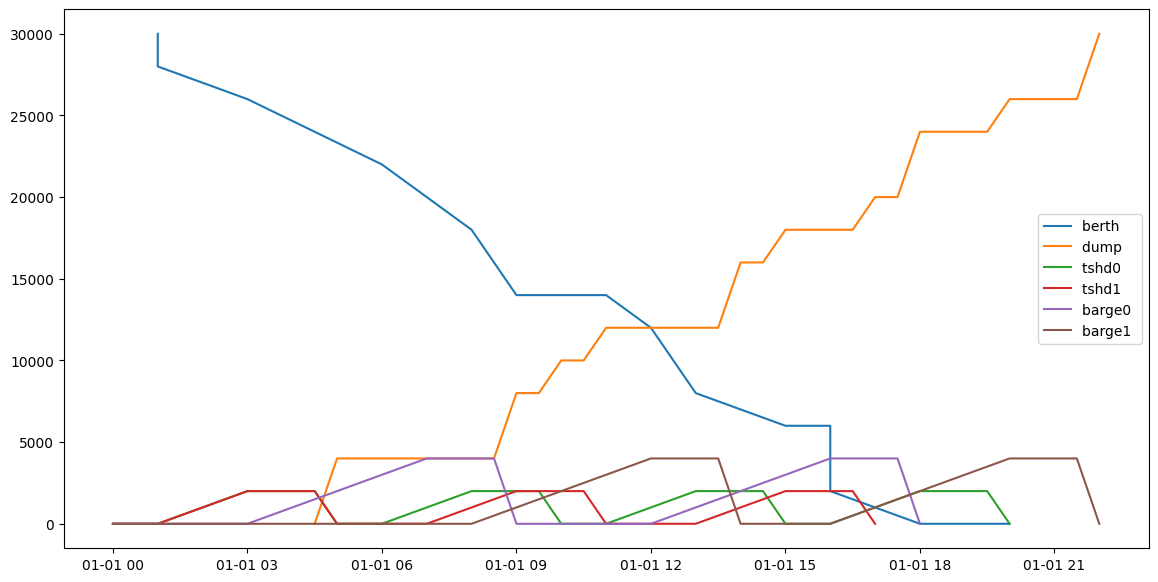

In [190]:
fig = plot.get_step_chart([berth, dump, *vessels.values()])

## 5. Exercise

Determine the total energy consumption of the maintenance dredging processes for different scenarios (different types and number of BHDs and TSHDs)
Draw a graph that compares the emission of each scenario and the duration of doing each job.

#### 5.1. Emission factors

In [191]:
from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()

# Define column names
table.field_names = ["fuel_type", "emission_factor (kg of CO2 per KWh)"]

# Add rows to the table
table.add_row(["Diesel", "0.9"])
table.add_row(["RMG 380", "0.8"])
table.add_row(["DMA", "0.6"])
table.add_row(["LNG", "0.5"])
table.add_row(["MGO", "0.7"])
table.add_row(["Gasoil", "0.85"])
table.add_row(["MDO", "0.75"])

# Print the table
print(table)

+-----------+-------------------------------------+
| fuel_type | emission_factor (kg of CO2 per KWh) |
+-----------+-------------------------------------+
|   Diesel  |                 0.9                 |
|  RMG 380  |                 0.8                 |
|    DMA    |                 0.6                 |
|    LNG    |                 0.5                 |
|    MGO    |                 0.7                 |
|   Gasoil  |                 0.85                |
|    MDO    |                 0.75                |
+-----------+-------------------------------------+


#### 5.2. Power consumption

In [192]:
# In this exercise, you can adopt maximum three identical barges

barge_empty = 300 # kW
barge_full = 500 # kW
barge_loading = 100 # kW
barge_unloading = 150 # kW
barge_WAIT = 30 # kW


barge_specs = pd.DataFrame.from_dict(
       {'sailing empty [kW]':{'barge I':barge_empty,'barge II':barge_empty,'barge III':barge_empty},
       'loading [kW]':{'barge I':barge_loading, 'barge II':barge_loading,'barge III':barge_loading},
       'sailing full [kW]':{'barge I':barge_full,'barge II':barge_full,'barge III':barge_full},
       'unloading [kW]':{'barge I':barge_unloading,'barge II':barge_unloading,'barge III':barge_unloading},
       'WAIT [kW]':{'barge I':barge_WAIT,'barge II':barge_WAIT,'barge III':barge_WAIT},
       'fuel_type':{'barge I':'Diesel','barge II':'Diesel','barge III':'Diesel'},
       }
)

barge_specs.index.name = 'barge_name' 
barge_specs.to_csv('barge_specs.csv', index=True)
vessel_specs = pd.read_csv('barge_specs.csv', index_col='barge_name')
vessel_specs

,sailing empty [kW],loading [kW],sailing full [kW],unloading [kW],WAIT [kW],fuel_type
barge_name,,,,,,
barge I,300,100,500,150,30,Diesel
barge II,300,100,500,150,30,Diesel
barge III,300,100,500,150,30,Diesel


### 6. Answers

Please quantify the duration and emissions of each scenario when utilizing differnt vessels from the fleet list (Backhoes and TSHDs).

* Barges are identical and maximum three of them can be used for re-allocating the sediments collected by the Backhoe dredger.
* Maximum one Backhoe dredger can be used for the maintenance dredging but the number of TSHDs are unlimited. However, if you choose too many of them, the simulation stops because not all of them are operating.